# Marginal Structural Models 

Reweights the data using Inverse Probability Weighting (IPW) to adjust for the influence of covariates on treatment and outcome. 


In [45]:
import numpy as np
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt 

In [8]:
np.random.seed(1)

In [23]:
n = 1000

covar1 = np.random.normal(loc = 10, scale = 5, size = n)  
a_linear = covar1 - 10 

# logistic transformation for probability
P_a = 1 / (1 + np.exp(-a_linear))

In [59]:
# Treatment
a = np.random.binomial(n=1, p=P_a, size=n)
# a

In [47]:
# outcome
noise = np.random.normal(loc=-10, scale=5, size=n)
y = 10*a + 0.5*covar1 + noise
y.shape

(1000,)

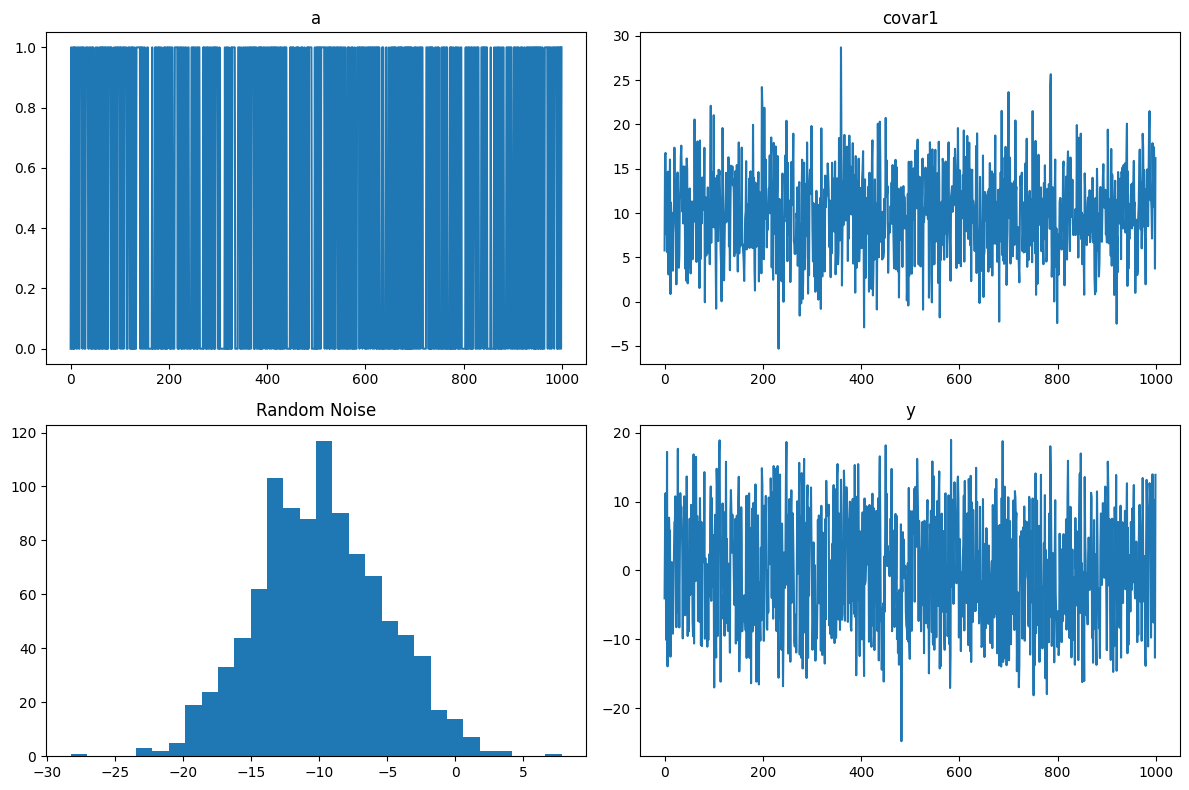

In [50]:
# Visualize the individual components
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(a)
plt.title('a')

plt.subplot(2, 2, 2)
plt.plot(covar1)
plt.title('covar1')

plt.subplot(2, 2, 3)
plt.hist(noise, bins=30)
plt.title('Random Noise')

plt.subplot(2, 2, 4)
plt.plot(y)
plt.title('y')

plt.tight_layout()
plt.show()


In [53]:
df = pd.DataFrame(
    {
        'var1':covar1,
        'a':a,
        'y':y
    }
)
df.head()

,var1,a,y
0,5.774023,0,-4.057651
1,16.550796,1,6.330120
2,16.787832,1,11.233817
3,9.549153,0,-6.477507
4,7.578489,0,-10.141183


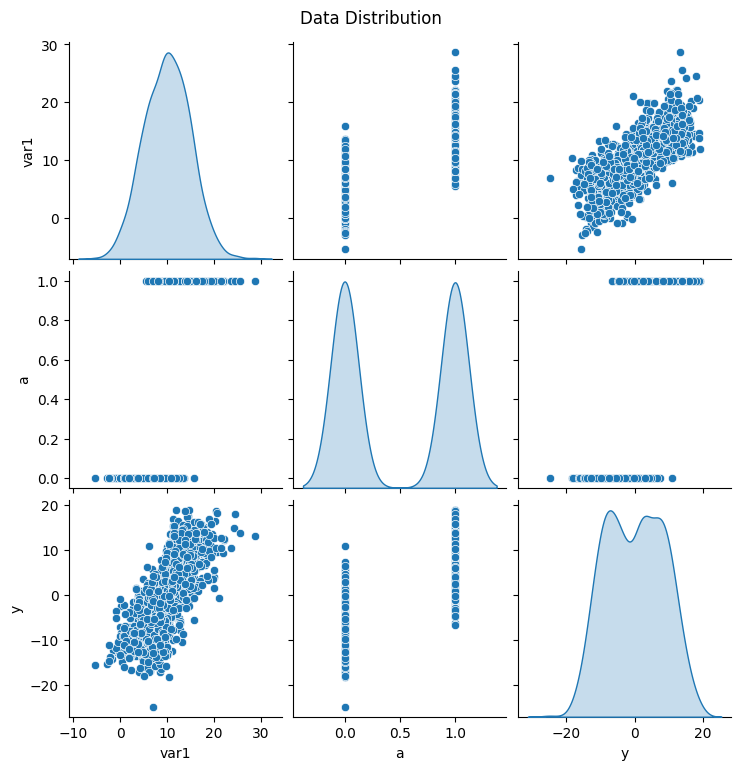

In [56]:
# Visualize the relationship between a, covar1, and y using Seaborn
sns.pairplot(data=df, diag_kind='kde')
plt.suptitle("Data Distribution", y=1.02)
plt.show()

### Inverse Probability Weighting (IPW)

Reweights the dataset to simulate a randomized trial. It assigns weights based on the probability of receiving the treatment, calculated from 2 logistic regression models. 

P_Numerator = Treatment ignoring confounders \
P_Denominator = Treatment accounting for confounders 

$
Weight = \frac{Probability\ from\ Numerator}{Probability\ from\ Denominator}
$

In [57]:
from sklearn.linear_model import LogisticRegression

In [61]:
logreg = LogisticRegression()
logreg.fit(df[['var1']], df['a'])

LogisticRegression()

In [66]:
propensity_score = logreg.predict_proba(df[['var1']])
propensity_score.shape

(1000, 2)

In [68]:
ps_predicted = propensity_score[:, 1]
df['ps'] = ps_predicted 
df['weights'] = np.where(df['a']==1, 1/ps_predicted, 1/(1-ps_predicted))

In [69]:
df.head()

,var1,a,y,ps,weights
0,5.774023,0,-4.057651,0.012345,1.012499
1,16.550796,1,6.330120,0.998648,1.001353
2,16.787832,1,11.233817,0.998938,1.001063
3,9.549153,0,-6.477507,0.369758,1.586693
4,7.578489,0,-10.141183,0.072938,1.078677


In [72]:
df['a']

0      0
1      1
2      1
3      0
4      0
      ..
995    0
996    1
997    1
998    0
999    1
Name: a, Length: 1000, dtype: int32

In [75]:
type(df['a'])

pandas.core.series.Series

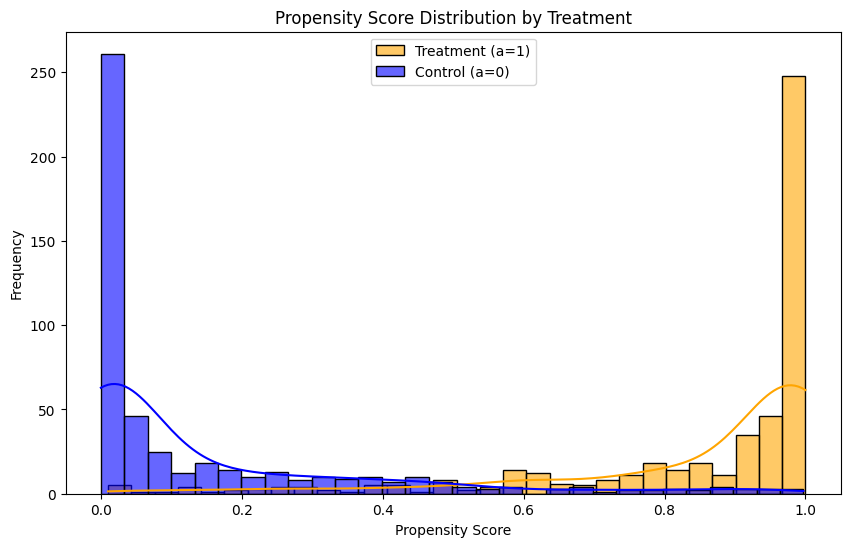

In [77]:
ps_treatment = df[df['a'] == 1]['ps']
ps_control = df[df['a'] == 0]['ps']

# Create the plot
plt.figure(figsize=(10, 6))
sns.histplot(ps_treatment, kde=True, color='orange', alpha=0.6, label='Treatment (a=1)', bins=30)
sns.histplot(ps_control, kde=True, color='blue', alpha=0.6, label='Control (a=0)', bins=30)

plt.title("Propensity Score Distribution by Treatment")
plt.xlabel("Propensity Score")
plt.ylabel("Frequency")
plt.legend()
plt.show()